In [7]:
from sparta_tools import moria
import numpy as np
import matplotlib.pyplot as plt

mpath = "/Users/cosinga/sims/sparta_output/L0063_N0256_CBol/moria_trees/moria_tree_orb_defs.hdf5"
massdefs = ['M200m_all_spa', 'Morb-all_all_spa', 'Morb-all_orb_spa', 'Mvir_all_spa', 'Mpeak']
pids = ['parent_id_cat', 'parent_id_orbinf']
others = ['mask_alive', 'mask_cut', 'id', 'x', 'R200m_all_spa']
redshifts = [0, 0.3, 0.5, 1, 1.5, 2, 4]
mconfig = moria.loadConfig(mpath)
mdata = moria.load(mpath, massdefs + pids + others)

In [8]:
snap_z = 0
snap_idx = np.argmin(np.abs(mconfig['simulation']['snap_z'] - snap_z))
alive = mdata['mask_alive'][snap_idx]
in_cut = mdata['mask_cut'][snap_idx]
orb_sub_mask = mdata[pids[1]][snap_idx, :] > 0
cat_sub_mask = mdata[pids[0]][snap_idx, :] > 0
sub_to_host_mask = ~orb_sub_mask & cat_sub_mask & alive
host_to_sub_mask = ~cat_sub_mask & orb_sub_mask & alive

In [9]:
morb = mdata[massdefs[1]]
morb_peak = np.maximum.accumulate(morb, axis = 0)
morb_peak = morb_peak[snap_idx, :]
pos_morb_mask = morb_peak > 0

sth_mask = sub_to_host_mask & pos_morb_mask
hts_mask = host_to_sub_mask & pos_morb_mask


In [20]:
sth_n = np.sum(sth_mask)
sth_rad = np.zeros(sth_n) - 1
sth_mfrac = np.zeros_like(sth_rad) - 1
sth_morb_peak = morb_peak[sth_mask]
pid_not_found_count = 0
# these are subhalos in the catalog definition only
pid = mdata['parent_id_cat'][snap_idx, sth_mask]
for i in range(sth_n):
    ipid = pid[i]
    host_midx = np.where(mdata['id'][snap_idx, :] == ipid)[0]

    if len(host_midx) == 0:
        pid_not_found_count += 1
        continue
    elif len(host_midx) > 1:
        print("too many hosts found")
    host_midx = host_midx[0]
    imorb = sth_morb_peak[i]
    host_morb = morb_peak[host_midx]
    host_pos = mdata['x'][snap_idx, host_midx, :]
    sub_pos = mdata['x'][snap_idx, sth_mask, :][i, :]
    host_rad = mdata['R200m_all_spa'][snap_idx, host_midx]
    # change to physical here, but right now using z = 0

    sth_rad[i] = np.sqrt(np.sum((host_pos - sub_pos)**2)) / host_rad * 1e3 / (1 + snap_z)
    sth_mfrac[i] = imorb / host_morb

print(pid_not_found_count)

0


In [26]:
hts_n = np.sum(hts_mask)
hts_rad = np.zeros(hts_n) - 1
hts_mfrac = np.zeros_like(hts_rad) - 1
hts_morb_peak = morb_peak[hts_mask]
pid_not_found_count = 0
# these are subhalos in the catalog definition only
pid = mdata['parent_id_orbinf'][snap_idx, hts_mask]
for i in range(hts_n):
    ipid = pid[i]
    host_midx = np.where(mdata['id'][snap_idx, :] == ipid)[0]

    if len(host_midx) == 0:
        pid_not_found_count += 1
        continue
    elif len(host_midx) > 1:
        print("too many hosts found")
    host_midx = host_midx[0]
    imorb = hts_morb_peak[i]
    host_morb = morb_peak[host_midx]
    host_pos = mdata['x'][snap_idx, host_midx, :]
    sub_pos = mdata['x'][snap_idx, hts_mask, :][i, :]
    host_rad = mdata['R200m_all_spa'][snap_idx, host_midx]
    # change to physical here, but right now using z = 0

    hts_rad[i] = np.sqrt(np.sum((host_pos - sub_pos)**2)) / host_rad * 1e3 / (1 + snap_z)
    hts_mfrac[i] = imorb / host_morb

print(pid_not_found_count)

0


/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_57275/1031011411.py:25: RuntimeWarning: divide by zero encountered in float_scalars
  hts_rad[i] = np.sqrt(np.sum((host_pos - sub_pos)**2)) / host_rad * 1e3 / (1 + snap_z)


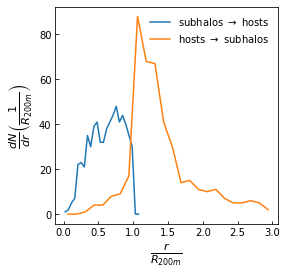

In [44]:
sthbins = np.linspace(0, 1.1, 25)
htsbins = np.linspace(0, 3, 25)
sth_hist, edges = np.histogram(sth_rad, sthbins)
sthx = (edges[1:] + edges[:-1]) / 2
hts_hist, edges = np.histogram(hts_rad, htsbins)
htsx = (edges[1:] + edges[:-1]) / 2
fig = plt.figure(figsize = (4, 4))
plt.plot(sthx, sth_hist, label = 'subhalos $\\rightarrow$ hosts')
plt.plot(htsx, hts_hist, label = "hosts $\\rightarrow$ subhalos")
plt.legend(frameon = False, loc = 'upper right')
plt.ylabel("$\\frac{dN}{dr} \\left(\\frac{1}{R_{200m}} \\right)$", fontsize = 16)
plt.xlabel("$\\frac{r}{R_{200m}}$", fontsize = 16)
ax = plt.gca()
ax.tick_params(which = 'both', direction = 'in')
plt.savefig('/Users/cosinga/overleaf/proposal_defense/figures/radial_dist.png', bbox_inches = 'tight', dpi = 150)



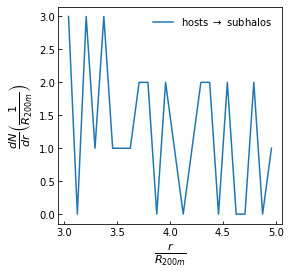

In [46]:
htsbins = np.linspace(3, 5, 25)
hts_hist, edges = np.histogram(hts_rad, htsbins)
htsx = (edges[1:] + edges[:-1]) / 2
fig = plt.figure(figsize = (4, 4))
plt.plot(htsx, hts_hist, label = "hosts $\\rightarrow$ subhalos")
plt.legend(frameon = False, loc = 'upper right')
plt.ylabel("$\\frac{dN}{dr} \\left(\\frac{1}{R_{200m}} \\right)$", fontsize = 16)
plt.xlabel("$\\frac{r}{R_{200m}}$", fontsize = 16)
ax = plt.gca()
ax.tick_params(which = 'both', direction = 'in')